<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocessing

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)

In [4]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [5]:
def overSampling(X, y, frac_over=0.1):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

In [6]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train, y_train = overSampling(X_train, y_train)

In [7]:
save_id = False 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Neural Network

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

keras.backend.clear_session()

model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(1000, activation='relu')) 
model.add(Dropout(0.7)) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.2)) 
# model.add(Dense(256, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(24, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(4, activation='relu')) 
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              734000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 735,001
Trainable params: 735,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=500, 
    validation_data=(X_val,y_val),
    verbose=1,
    shuffle = True , #class_weight = {0: 1, 1: ratio / 2}
)

Epoch 1/20
753/753 [==============================] - 5s 6ms/step - loss: 0.2573 - accuracy: 0.9105 - val_loss: 0.1367 - val_accuracy: 0.9620
Epoch 2/20
753/753 [==============================] - 3s 4ms/step - loss: 0.2246 - accuracy: 0.9209 - val_loss: 0.1301 - val_accuracy: 0.9667
Epoch 3/20
753/753 [==============================] - 4s 5ms/step - loss: 0.2182 - accuracy: 0.9235 - val_loss: 0.1311 - val_accuracy: 0.9651
Epoch 4/20
753/753 [==============================] - 4s 5ms/step - loss: 0.2084 - accuracy: 0.9266 - val_loss: 0.1308 - val_accuracy: 0.9655
Epoch 5/20
753/753 [==============================] - 3s 5ms/step - loss: 0.2057 - accuracy: 0.9278 - val_loss: 0.1308 - val_accuracy: 0.9671
Epoch 6/20
753/753 [==============================] - 3s 4ms/step - loss: 0.2012 - accuracy: 0.9291 - val_loss: 0.1248 - val_accuracy: 0.9668
Epoch 7/20
753/753 [==============================] - 3s 4ms/step - loss: 0.1999 - accuracy: 0.9293 - val_loss: 0.1253 - val_accuracy: 0.9673
Epoch 

# Performance evaluation

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

3691/3691 [==============================] - 7s 2ms/step - loss: 0.1074 - accuracy: 0.9720

Test Loss:	 0.10743599385023117
Test Accuracy:	 0.9719745516777039


In [12]:
y_pred = model.predict(X_test)

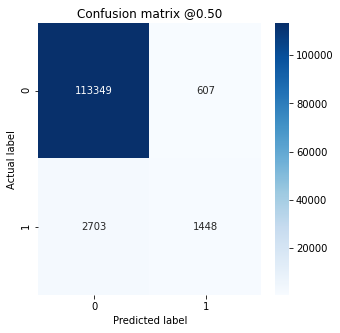

In [13]:
mf.plot_cm(y_test, y_pred, 'Blues')

AUC:  0.8800629899469075


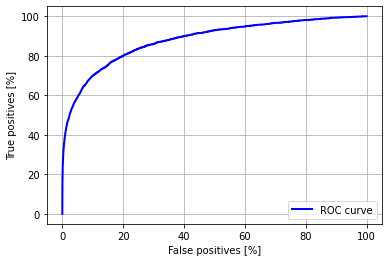

In [14]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.48683108770979744


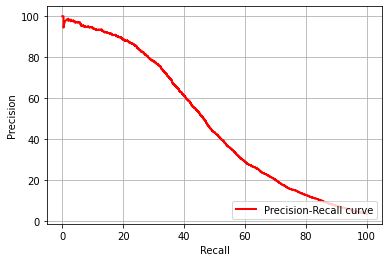

In [15]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')

In [16]:
y_predicted = []
for prob in y_pred:
  if prob >= 0.5:
    y_predicted.append(1)
  else:
    y_predicted.append(0)

In [17]:
from sklearn.metrics import f1_score, recall_score, precision_score
print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))

F1 score:  0.4666451820818563
Recall:  0.3488316068417249
Precision:  0.7046228710462287
